## CS441: Applied ML - HW 3

## Part 1: Spam Detection with Naive Bayes Classifier

We want to classify text messages as “spam” (unwanted) or “ham” (genuine). We will use data (spam.csv) from the Kaggle SMS spam dataset. We’ve provided the loading and pre-processing code to generate:
* `unique_words`: the unique set of words in the dataset
* `(x_train, y_train, msg_train)`: counts of words in each message, spam (y=1) or not spam (y=-1) labels, and the message string for each training sample; `x_train[n][j]` is the count of the `j`th word in the `n`th sample.
* `*_val` and `*_test`, similar to above, for the val and test splits
We will use a Naive Bayes Classifier.

See assignment for details (equations are not easy to reproduce here).

In [2]:
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw3/" # choose proper location

# don't change the code below

# read data
with open(datadir + 'spam.csv', encoding='latin-1') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    y = np.zeros((10000,))
    X = []
    n = 0
    rownum = 0
    for row in datareader:
      if rownum == 0:
        rownum += 1
        continue
      rownum += 1
      if row[0]=='ham':
        y[n] = -1
      else:
        y[n] = 1
      X.append(row[1])
      n += 1
y= y[:n]

# y[n] = -1 for ham, 1 for spam
print(y[0])
print(X[0])

# parse the text messages into words and count the words in each row
vectorizer = CountVectorizer(analyzer='word')
word_count = vectorizer.fit_transform(X).toarray()

print(f"We have {word_count.shape[0]} examples with {word_count.shape[1]} unique words.")
unique_words = vectorizer.get_feature_names_out()

# split data into train (50%), validation (25%), and test (25%)
x_train = word_count[::2]
y_train = y[::2]
msg_train = X[::2]
x_val = word_count[1::4]
y_val = y[1::4]
msg_val = X[1::4]
x_test = word_count[3::4]
y_test = y[3::4]
msg_test = X[3::4]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-1.0
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
We have 5572 examples with 8672 unique words.


#### 1. Train your Naive Bayes Classifier
I.e. P(y), P(w|y)) using the train set with =1 and compute the accuracy on the val set.  You should get P(y=1)=0.142, P(call|spam) = 0.0104, and P(call|ham)=0.0029. Your validation accuracy should be higher than 95%.

In [3]:
alpha = 1.0
V = x_train.shape[1]


n_spam = (y_train == 1).sum()
n_ham  = (y_train == -1).sum()
prior = np.array([n_ham, n_spam], dtype=float) / y_train.size
log_prior = np.log(prior + 1e-9)


X_spam = x_train[y_train == 1].sum(axis=0).astype(float)
X_ham  = x_train[y_train == -1].sum(axis=0).astype(float)
pw_spam = (X_spam + alpha) / (X_spam.sum() + alpha * V)
pw_ham  = (X_ham  + alpha) / (X_ham.sum()  + alpha * V)


log_pw = np.vstack([np.log(pw_ham), np.log(pw_spam)])


try:
    call_idx = np.where(unique_words == "call")[0][0]
    print(f"P(y=1)={prior[1]:.3f}, P(call|spam)={pw_spam[call_idx]:.4f}, P(call|ham)={pw_ham[call_idx]:.4f}")
except IndexError:
    print(f'P(y=1)={prior[1]:.3f}  (token "call" not in vocabulary)')


ll_val = x_val @ log_pw.T + log_prior

y_pred_val = ll_val.argmax(axis=1)
val_acc = (y_pred_val == (y_val + 1) // 2).mean()
print(f"Validation accuracy = {val_acc:.4f}")

P(y=1)=0.142, P(call|spam)=0.0104, P(call|ham)=0.0029
Validation accuracy = 0.9813


#### 2. Data exploration
What are the 10 spammiest words (i.e. words with highest  logP(wj|spam)- logP(wj|ham))?  What are the 10 hammiest words? Which val message is the spammiest ham (message with highest spam score but y=-1)? Which is hammiest spam (message with lowest spam score but y=1)?  Spammiest spam? Hammiest ham?

In [4]:
import numpy as np


log_odds = log_pw[1] - log_pw[0]

sidx = np.argsort(log_odds)[-10:]
print("10 spammiest words:")
print("\n".join([unique_words[i] for i in sidx]))


hidx = np.argsort(log_odds)[:10]
print("\n10 hammiest words:")
print("\n".join([unique_words[i] for i in hidx]))


def choose_data():
    sets = [
        (x_val, y_val, msg_val),
        (x_test, y_test, msg_test),
        (x_train, y_train, msg_train),
        (np.vstack([x_val, x_test]),
         np.concatenate([y_val, y_test]),
         np.array(list(msg_val)+list(msg_test), dtype=object)),
        (np.vstack([x_train, x_val, x_test]),
         np.concatenate([y_train, y_val, y_test]),
         np.array(list(msg_train)+list(msg_val)+list(msg_test), dtype=object))
    ]
    for X,Y,M in sets:

        if (-1 in Y) and (1 in Y):
            return X,Y,M
    return sets[-1]

X,Y,M = choose_data()
ll = X @ log_pw.T + log_prior
p = 1/(1+np.exp(-np.clip(ll[:,1]-ll[:,0], -50, 50)))

ham, spam = (Y==-1), (Y==1)


i_sh = np.where(ham)[0][np.argmax(p[ham])] if np.any(ham) else None
i_hs = np.where(spam)[0][np.argmin(p[spam])] if np.any(spam) else None
i_ss = np.where(spam)[0][np.argmax(p[spam])] if np.any(spam) else None
i_hh = np.where(ham)[0][np.argmin(p[ham])] if np.any(ham) else None


if i_sh is not None:
    print("\nSpammiest ham\n"+M[i_sh]+"\nscore="+str(float(p[i_sh])))
else:
    print("\nSpammiest ham: Not found")

if i_hs is not None:
    print("\nHammiest spam\n"+M[i_hs]+"\nscore="+str(float(p[i_hs])))
else:
    print("\nHammiest spam: Not found")

if i_ss is not None:
    print("\nSpammiest spam\n"+M[i_ss]+"\nscore="+str(float(p[i_ss])))
else:
    print("\nSpammiest spam: Not found")

if i_hh is not None:
    print("\nHammiest ham\n"+M[i_hh]+"\nscore="+str(float(p[i_hh])))
else:
    print("\nHammiest ham: Not found")

10 spammiest words:
18
cs
16
500
tone
www
150p
uk
prize
claim

10 hammiest words:
gt
lt
he
but
lor
da
she
later
ì_
wat

Spammiest ham
Waqt se pehle or naseeb se zyada kisi ko kuch nahi milta,Zindgi wo nahi he jo hum sochte hai Zindgi wo hai jo ham jeetey hai..........
score=0.9999875249999429

Hammiest spam
LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms
score=9.411404471768725e-10

Spammiest spam
Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed å£1000 cash or å£5000 prize!
score=1.0

Hammiest ham
Wow. I never realized that you were so embarassed by your accomodations. I thought you liked it, since i was doing the best i could and you always seemed so happy about \the cave\". I'm sorry I didn't and don't have more to give. I'm sorry i offered. I'm sorry your room was so embarassing."
score=1.928749847963918e-22


#### 3. Precision-recall trade-off
You want to flag spam messages with minimal false positives. Using the val set, compute precision/recall and display the PR curve. Programmatically, find the threshold with highest recall, where precision > 0.99.  Report the accuracy, precision, and recall on the test set using the same model and the selected threshold.

threshold=0.997675
test_acc=0.0998 precision=1.0000 recall=0.8081


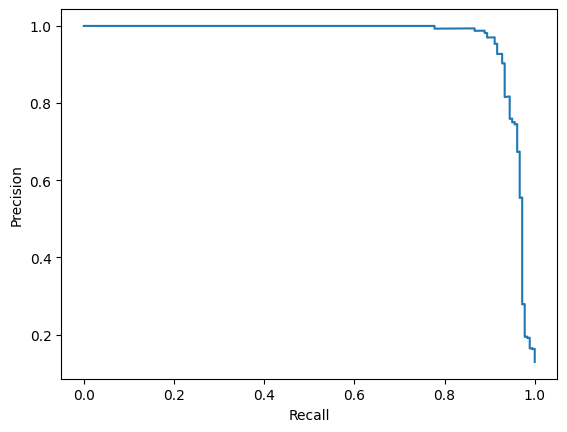

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


# TO DO


ll = x_val @ log_pw.T + log_prior
p_val = 1/(1+np.exp(-np.clip(ll[:,1]-ll[:,0], -50, 50)))
prec, rec, thr = precision_recall_curve(y_val, p_val)
m = np.where(prec[1:] > 0.99)[0]
j = m[np.argmax(rec[1:][m])] if m.size else np.argmax(prec[1:])
best_thr = float(thr[j])

ll_t = x_test @ log_pw.T + log_prior
p_test = 1/(1+np.exp(-np.clip(ll_t[:,1]-ll_t[:,0], -50, 50)))
y_pred = (p_test >= best_thr).astype(int)
tp = int(((y_test==1)&(y_pred==1)).sum())
tn = int(((y_test==0)&(y_pred==0)).sum())
fp = int(((y_test==0)&(y_pred==1)).sum())
fn = int(((y_test==1)&(y_pred==0)).sum())
acc = (tp+tn)/y_test.size
pre = tp/(tp+fp) if tp+fp>0 else 0.0
recall = tp/(tp+fn) if tp+fn>0 else 0.0
print(f"threshold={best_thr:.6f}")
print(f"test_acc={acc:.4f} precision={pre:.4f} recall={recall:.4f}")

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Part 2: Robust Estimation

The corrupted salary dataset has three variables: salary, years, school.  Salary is the reported salary of each person.  Years is the number of years of experience in the job.  School is the university where the person last had a degree. For the core assignment, we’ll only use salary, and the stretch goals will use the other two variables. Some of the reported salary information is wrong (some incorrect value is provided), so we want to learn things from the data in a way that is robust to the wrong data. We refer to correctly entered data as “valid”.

Estimate the true mean, standard deviation, min, and max of the salaries using three different methods.

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw3/"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Assume no noise
Compute the statistics for the data as a whole

In [7]:
# TO DO
salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)
print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile. Adjust estimates of the min and max by assuming that the valid data has a uniform distribution (see lecture on robust fitting).

In [8]:
pct = 0.05

# TO DO
L = np.percentile(salary, 100*pct)
U = np.percentile(salary, 100*(1-pct))
mid = salary[(salary>=L)&(salary<=U)]
salary_mu = mid.mean()
salary_std = mid.std()
rng = (U - L)/0.90
salary_min = 0.5*(L + U - rng)
salary_max = 0.5*(L + U + rng)
print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 113878.65  Std: 15876.450453939286  Min: 75493.80000000002   Max: 159900.79999999973


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary. For mean and std, report the estimated mean and std of the valid salary distribution. For min and max, report the min and max salaries that have greater than 50% chance of being valid. Also report the estimated probability that a random sample is valid, and the first five indices of salaries that are not likely to be valid.

In [9]:
# TO DO


a, b = salary.min(), salary.max()
mu, sigma, pi = np.median(salary), salary.std(), 0.9
U = 1.0/(b - a + 1e-12)
for _ in range(100):
    N = (1.0/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*((salary - mu)/sigma)**2)
    r = (pi*N) / (pi*N + (1 - pi)*U + 1e-12)
    mu = (r*salary).sum() / (r.sum() + 1e-12)
    sigma = np.sqrt((r*((salary - mu)**2)).sum() / (r.sum() + 1e-12))
    pi = r.mean()

mask = r > 0.5
salary_mu, salary_std = mu, sigma
salary_min = salary[mask].min() if mask.any() else a
salary_max = salary[mask].max() if mask.any() else b

print('P(valid)={:.3f}'.format(pi))

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

# print the first five indices of salaries that are not likely to be valid
print(np.where(r<0.5)[0][:5]) # Replaced p_valid_given_s with r

P(valid)=0.942
Mean: 111984.38414085866  Std: 17966.359253827854  Min: 64694.0   Max: 169008.0
[ 18  28  49 127 128]


## Part 3: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [10]:
# TO DO (optional)
import numpy as np
from sklearn.metrics import precision_recall_curve

def train_nb(X,y,alpha):
    V=X.shape[1]
    n1=(y==1).sum(); n0=(y==0).sum()
    lp=np.log(np.array([n0,y.size-n0])/y.size+1e-12)
    xs=X[y==1].sum(0).astype(float); xh=X[y==0].sum(0).astype(float)
    pw1=(xs+alpha)/(xs.sum()+alpha*V); pw0=(xh+alpha)/(xh.sum()+alpha*V)
    return lp, np.vstack([np.log(pw0+1e-12), np.log(pw1+1e-12)])

def score(lp,lw,X):
    ll=X@lw.T+lp
    d=np.clip(ll[:,1]-ll[:,0],-50,50)
    return 1/(1+np.exp(-d))

results=[]
best=None
for binary in [0,1]:
    df_mask=(x_train>0).sum(0)>=1
    for df_min in [1,3]:
        df_mask=(x_train>0).sum(0)>=df_min
        if df_mask.sum()==0:
            continue
        Xt=x_train[:,df_mask]; Xv=x_val[:,df_mask]; Xte=x_test[:,df_mask]
        if binary: Xt=(Xt>0).astype(int); Xv=(Xv>0).astype(int); Xte=(Xte>0).astype(int)
        for a in [0.2,0.5,1.0,2.0,4.0]:
            lp,lw=train_nb(Xt,y_train,a)
            pv=score(lp,lw,Xv)
            prec,rec,thr=precision_recall_curve(y_val,pv)
            m=np.where(prec[1:]>0.99)[0]
            j=m[np.argmax(rec[1:][m])] if m.size else np.argmax(prec[1:])
            recall_target=rec[1:][j] if m.size else rec[1:][j]
            results.append((recall_target,a,binary,df_min,j,lp,lw,thr,Xte))
best=max(results,key=lambda t:t[0])
recall_val,a,binary,df_min,j,lp,lw,thr,Xte=best
pt=score(lp,lw,Xte); best_thr=float(thr[j])
yp=(pt>=best_thr).astype(int)
tp=int(((y_test==1)&(yp==1)).sum()); tn=int(((y_test==0)&(yp==0)).sum())
fp=int(((y_test==0)&(yp==1)).sum()); fn=int(((y_test==1)&(yp==0)).sum())
acc=(tp+tn)/y_test.size; pre=tp/(tp+fp) if tp+fp>0 else 0.0; rec=tp/(tp+fn) if tp+fn>0 else 0.0
print("best:", {"alpha":a,"binary":bool(binary),"df_min":df_min,"thr":best_thr})
print("test_acc={:.4f} precision={:.4f} recall={:.4f}".format(acc,pre,rec))





def em_valid_probs(s):
    a,b=s.min(),s.max()
    mu=np.median(s); sg=s.std(); pi=0.9; U=1/(b-a+1e-12)
    for _ in range(100):
        N=(1/(np.sqrt(2*np.pi)*sg))*np.exp(-0.5*((s-mu)/sg)**2)
        r=(pi*N)/(pi*N+(1-pi)*U+1e-12)
        mu=(r*s).sum()/(r.sum()+1e-12)
        sg=np.sqrt((r*((s-mu)**2)).sum()/(r.sum()+1e-12))
        pi=r.mean()
    return r

r = em_valid_probs(salary)
m = r>0.5
overall = salary[m].mean()
uiuc = salary[m & (school==0)].mean() if (m & (school==0)).any() else np.nan
mit  = salary[m & (school==1)].mean() if (m & (school==1)).any() else np.nan
corn = salary[m & (school==2)].mean() if (m & (school==2)).any() else np.nan
print("Overall {:.0f}".format(overall))
print("School 0 (UIUC) {:.0f}".format(uiuc))
print("School 1 (MIT) {:.0f}".format(mit))
print("School 2 (Cornell) {:.0f}".format(corn))









def em_valid_probs(s):
    a,b=s.min(),s.max()
    mu=np.median(s); sg=s.std(); pi=0.9; U=1/(b-a+1e-12)
    for _ in range(100):
        N=(1/(np.sqrt(2*np.pi)*sg))*np.exp(-0.5*((s-mu)/sg)**2)
        r=(pi*N)/(pi*N+(1-pi)*U+1e-12)
        mu=(r*s).sum()/(r.sum()+1e-12)
        sg=np.sqrt((r*((s-mu)**2)).sum()/(r.sum()+1e-12))
        pi=r.mean()
    return r

r = em_valid_probs(salary)
w = r
coef = np.polyfit(years, salary, 1, w=w)
slope = coef[0]
print("Increase per year (slope) {:.2f}".format(slope))



best: {'alpha': 0.2, 'binary': False, 'df_min': 1, 'thr': 1.0}
test_acc=0.1213 precision=1.0000 recall=0.9826
Overall 112066
School 0 (UIUC) 119026
School 1 (MIT) 105468
School 2 (Cornell) 112027
Increase per year (slope) 1024.94


In [11]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/MyDrive/CS441/hw3" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_HW3_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/


AssertionError: NOTEBOOK NOT FOUND: /content/drive/MyDrive/CS441/hw3/CS441_HW3_Solution.ipynb